### Week 1 Homework
##### Angela Spencer - 12/8/2021

#### 1.	What scale of measurement applies to timeseries data? Is timeseries data continuous or discrete? Why?

Timeseries data is measured in an interval scale, it is numeric and the values have specific order and spacing such as hours, days, or years. Timeseries data is usually discrete because observations are made at specific intervals rather than constantly, but it is also possible to have continuous timeseries data where measurements are so close together that they are seemingly continuous.

#### 2.	What does ARIMA stand for? Break down and explain each piece in the name.

ARIMA stands for AutoRegression, order of Integration, Moving Average - it is a linear regression model that performs three types of analysis on the data:

1. Autoregression: uses past events to predict future ones by finding correlations between lags
2. Order of Integration: used to make a series stationary
3. Moving Average: creates a average value that is constantly adjusting based on new information

#### 3.	Using the data in the temperatures/ folder. Write a function that efficiently converts every column to a different temperature scale: one that is more common than Kelvin.

In [64]:
import pandas as pd
import numpy as np
import os
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [18]:
#import csv as dataframe, parse date to datetime, set index to date column
kelvin_df = pd.read_csv('temperature.csv', parse_dates=True, index_col='datetime')
kelvin_df.shape

(45253, 36)

In [19]:
#drop rows with NaN values
kelvin_df_dropped = kelvin_df.dropna()
kelvin_df_dropped.shape

(44430, 36)

In [20]:
#define function that accepts df and converts kelvin values to celsius, returning a new df
celsius_conversion = round(kelvin_df_dropped.apply(lambda num: num-273.15),2)

fahrenheit_conversion = round(kelvin_df_dropped.apply(lambda x: (x-273.15)*9/5+32),2)

print(kelvin_df_dropped.iloc[0,0])
print(celsius_conversion.iloc[0,0])
print(fahrenheit_conversion.iloc[0,0])

284.63
11.48
52.66


In [21]:
celsius_conversion.head(3)

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,11.48,8.93,16.33,8.65,18.72,18.38,20.26,23.45,11.97,11.46,...,12.48,15.07,12.68,14.02,34.44,32.32,37.43,31.25,31.25,30.35
2012-10-01 14:00:00,11.48,8.93,16.32,8.65,18.72,18.38,20.25,23.46,12.00,11.46,...,12.51,15.10,12.68,14.04,34.44,31.16,37.35,31.25,31.25,30.35
2012-10-01 15:00:00,11.48,8.94,16.31,8.64,18.71,18.39,20.24,23.48,12.08,11.45,...,12.61,15.18,12.70,14.08,34.24,31.13,37.26,31.25,31.25,30.35


#### 4.	Write a function that efficiently fills in missing values in every column, excluding trailing NANs. That is: if there's temperature data on either side of a timestamp, it should interpolate through it. But if data stopped being collected, your function should leave nans at the end.

In [22]:
#use .interpolate to fill non-trailing NaNs
kelvin_df_interpolate = kelvin_df.interpolate(limit_area='inside')

#print total number of NaNs before and after interpolation
print(kelvin_df_interpolate.isna().sum().sum())
print(kelvin_df.isna().sum().sum())

7955
8030


#### 5.	Find all cities A and B where city A is warmer than city B in the summer, but also colder than city B in the winter, on average.

In [23]:
#2012-10-01-12:00:00 min
#2017-11-30-00:00:00 max

#isolate summer months and winter months in unique series
summer_months = fahrenheit_conversion.loc[fahrenheit_conversion.index.month.isin([6,7,8])]
winter_months = fahrenheit_conversion.loc[fahrenheit_conversion.index.month.isin([12,1,2])]

#calculate mean of each series to find mean temperature for that season
summer_months_avg = summer_months.mean()
winter_months_avg = winter_months.mean()

#create a new dataframe with summer and winter averages
seasonal_avg_df = pd.concat(
    [summer_months_avg.rename("Summer Average"), 
     winter_months_avg.rename("Winter Average")], axis=1)
seasonal_avg_df.head()

,Summer Average,Winter Average
Vancouver,64.618817,38.753053
Portland,67.117580,40.123098
San Francisco,65.733608,51.241873
Seattle,64.747178,40.742606
Los Angeles,72.455433,54.791042


In [24]:
#create empty lists to hold the comparison cities
cityA = []
cityA_summer = []
cityA_winter = []

cityB = []
cityB_summer = []
cityB_winter = []

#create outer loop that compares city A to each city
for rowA in range(len(seasonal_avg_df.index)):
    
    city = seasonal_avg_df.index[rowA]
    summerA = seasonal_avg_df.iloc[rowA,0]
    winterA = seasonal_avg_df.iloc[rowA,1]
    
    #create an inner loop that compares cityA and cityB
    for rowB in range(len(seasonal_avg_df.index)):
        
        summerB = seasonal_avg_df.iloc[rowB,0]
        winterB = seasonal_avg_df.iloc[rowB,1]
        
        #if city != seasonal_avg_df.index[rowB]:
        
        #compare summer and winter averages and append to list
        if (summerA > summerB) & (winterA < winterB):

            cityA.append(seasonal_avg_df.index[rowA])
            cityB.append(seasonal_avg_df.index[rowB])
            cityA_summer.append(seasonal_avg_df.iloc[rowA,0])
            cityA_winter.append(seasonal_avg_df.iloc[rowA,1])
            cityB_summer.append(seasonal_avg_df.iloc[rowB,0])
            cityB_winter.append(seasonal_avg_df.iloc[rowB,1])

        #if comparison fails, pass
        else:
            pass


In [25]:
#convert list to series and concat series into dataframe
#rename columns 
comparison_df = pd.concat([pd.Series(cityA),pd.Series(cityA_summer), pd.Series(cityA_winter),
                           pd.Series(cityB),pd.Series(cityB_summer), pd.Series(cityB_winter)], 
                          axis=1).rename(columns = ({0:'City A', 1:'City A Summer', 2:'City A Winter',
                                                     3:'City B', 4:'City B Summer', 5:'City B Winter'}))
comparison_df

,City A,City A Summer,City A Winter,City B,City B Summer,City B Winter
0,Portland,67.117580,40.123098,San Francisco,65.733608,51.241873
1,Portland,67.117580,40.123098,Seattle,64.747178,40.742606
2,Las Vegas,88.723296,46.542773,San Francisco,65.733608,51.241873
3,Las Vegas,88.723296,46.542773,Los Angeles,72.455433,54.791042
4,Las Vegas,88.723296,46.542773,San Diego,69.965765,54.690291
...,...,...,...,...,...,...
162,Tel Aviv District,81.410525,57.353867,Nahariyya,79.537521,57.994031
163,Eilat,88.684950,57.473846,Jacksonville,81.195369,58.598080
164,Eilat,88.684950,57.473846,Miami,82.670907,70.944587
165,Eilat,88.684950,57.473846,Haifa,82.329074,60.003621


#### 6.	For two of the cities you found in question 5 (there are many possible answers), clean up the data via rolling averages and plot a clear visual. Explain how rolling average differs from moving average (MA) model.

The rolling average method picks a number to serve as the lag, but there is no way to pick a statistically significant window to calculate on.  The MA model uses the Autocorrelation Factor to find the statistically significant number of lags for the model to impliment.

In [26]:
#Select fahrenheit df, drop null values
fahrenheit_dropped = fahrenheit_conversion.dropna()
fahrenheit_df = fahrenheit_dropped.reset_index()

#slice desired columns
LV_SD_slice = fahrenheit_df[['datetime','Las Vegas', 'San Diego']]

#drop first 10 rows, and last row to remove partial days
LV_SD_drop = LV_SD_slice.drop([0,1,2,3,4,5,6,7,8,9,10,44429])

#reset index values
LV_SD = LV_SD_drop.reset_index()
LV_SD.drop(columns=['index'], inplace=True)

LV_SD

,datetime,Las Vegas,San Diego
0,2012-10-02 00:00:00,68.26,65.27
1,2012-10-02 01:00:00,68.24,65.29
2,2012-10-02 02:00:00,68.22,65.30
3,2012-10-02 03:00:00,68.20,65.32
4,2012-10-02 04:00:00,68.18,65.34
...,...,...,...
44413,2017-10-27 19:00:00,75.42,77.43
44414,2017-10-27 20:00:00,77.50,79.23
44415,2017-10-27 21:00:00,79.30,79.79
44416,2017-10-27 22:00:00,81.34,80.62


In [27]:
#SMA(simple moving average, window 1 day, 24 observations)
#add as a new column to df
LV_SD_SMA = LV_SD
LV_SD_SMA['Las Vegas SMA'] = round(LV_SD.iloc[:,1].rolling(window=24).mean(),2)
LV_SD_SMA['San Diego SMA'] = round(LV_SD.iloc[:,2].rolling(window=24).mean(),2)
LV_SD_SMA

,datetime,Las Vegas,San Diego,Las Vegas SMA,San Diego SMA
0,2012-10-02 00:00:00,68.26,65.27,NaN,NaN
1,2012-10-02 01:00:00,68.24,65.29,NaN,NaN
2,2012-10-02 02:00:00,68.22,65.30,NaN,NaN
3,2012-10-02 03:00:00,68.20,65.32,NaN,NaN
4,2012-10-02 04:00:00,68.18,65.34,NaN,NaN
...,...,...,...,...,...
44413,2017-10-27 19:00:00,75.42,77.43,71.13,69.77
44414,2017-10-27 20:00:00,77.50,79.23,71.03,69.36
44415,2017-10-27 21:00:00,79.30,79.79,70.93,68.94
44416,2017-10-27 22:00:00,81.34,80.62,70.80,68.61


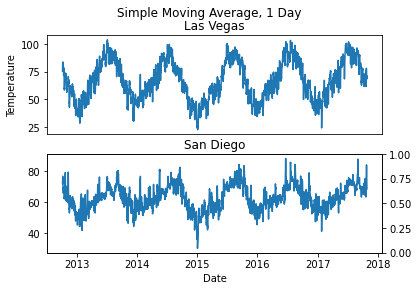

In [28]:
#create graph for SMA columns

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Simple Moving Average, 1 Day')

ax1.plot(LV_SD_SMA['datetime'], LV_SD_SMA['Las Vegas SMA'])
ax1.set_title('Las Vegas')
ax1.axes.xaxis.set_ticks([])
ax1.set_ylabel('Temperature')

ax2.twinx()
ax2.plot(LV_SD_SMA['datetime'], LV_SD_SMA['San Diego SMA'])
ax2.set_title('San Diego')
ax2.set_xlabel('Date')

plt.show()

#### 7.	Perform SARIMA on five cities, iterating through the cities programmatically. Explain your results.

In [41]:
#create a new df with 5 cities from the original df
five_cities = fahrenheit_dropped[['Vancouver','Portland','San Francisco',
                                  'Seattle','Los Angeles']]

#resample to get average weekly temp
five_cities = five_cities.resample(rule ='W').mean()
five_cities

#city1 = five_cities[['Vancouver']]
#city2 = five_cities[['Portland']]
#city3 = five_cities[['San Francisco']]
#city4 = five_cities[['Seattle']]
#city5 = five_cities[['Los Angeles']]

,Vancouver,Portland,San Francisco,Seattle,Los Angeles
datetime,,,,,
2012-10-07,53.344323,57.716710,66.657419,53.986581,70.688645
2012-10-14,52.827440,54.486012,59.047440,55.192381,65.053810
2012-10-21,51.380119,54.647440,64.827679,53.352738,71.224762
2012-10-28,43.736845,46.289167,57.058452,45.030476,66.635476
2012-11-04,51.271607,56.443393,58.953155,54.405774,63.561607
...,...,...,...,...,...
2017-10-01,58.527500,62.499524,67.311429,60.576190,71.527202
2017-10-08,52.278036,55.240833,62.731786,52.728929,69.404881
2017-10-15,47.623452,48.543452,61.735595,47.675417,68.649524


Text(0, 0.5, 'Temperature °F')

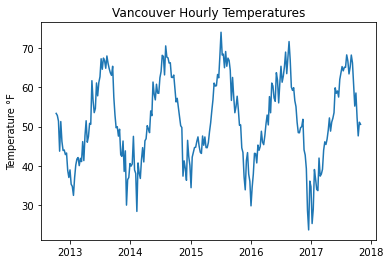

In [43]:
#view data
plt.figure()
plt.plot(five_cities['Vancouver'])
plt.title('Vancouver Hourly Temperatures')
plt.ylabel('Temperature °F')

Text(0, 0.5, 'Temperature °F')

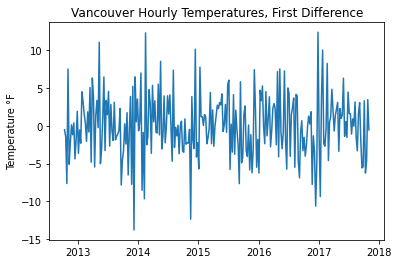

In [48]:
#remove trend by taking first difference
first_diff = five_cities['Vancouver'].diff()

#view data after first difference, use Integrated order = 1
#still a seasonal pattern
plt.figure()
plt.plot(first_diff)
plt.title('Vancouver Hourly Temperatures, First Difference')
plt.ylabel('Temperature °F')

C:\Program Files\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Program Files\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


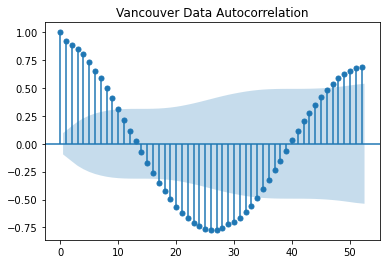

In [67]:
#ACF
#compute CI
ci = 1.96/sqrt(len(five_cities))

acf_array = acf(five_cities['Vancouver'])
plot_acf(five_cities['Vancouver'], lags = 52, alpha = ci)
plt.title('Vancouver Data Autocorrelation')
plt.show()

#see spikes at 6 months and 12 months, seasonal MA process for 24 weeks 
#there are significant lags outside of those seasonal trends as well

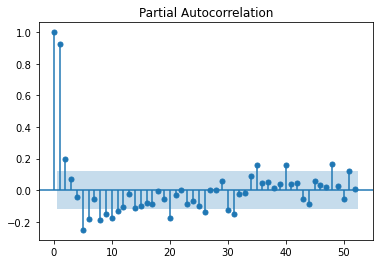

In [66]:
#PACF

# Plot PACF for AR(1)
plot_pacf(five_cities['Vancouver'], lags = 52)
plt.show()

In [78]:
#fit SARIMA model

#order coefficients
my_order = (0,1,1)
my_seasonal_order = (1,0,0,52)

#define model
model = SARIMAX(five_cities['Vancouver'], order=my_order, seasonal_order=my_seasonal_order)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Vancouver   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                -741.576
Date:                             Fri, 10 Dec 2021   AIC                           1489.152
Time:                                     16:29:38   BIC                           1499.880
Sample:                                 10-07-2012   HQIC                          1493.463
                                      - 10-29-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2818      0.052     -5.425      0.000      -0.384      -0.180
ar.S.L52       0.1943      0.077      2.510      0.012       0.043       0.346
sigma2        15.9942      1.212     13.194      0.000      13.618      18.370
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.05
Prob(Q):                              0.98   Prob(JB):                         0.03
Heteroskedasticity (H):               0.94   Skew:                            -0.21
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### a.	Graph the predicted values 30 days out.

#### b.	Explain what you see when you perform results.summary() on the cities in question 7. 

#### DataCamp Certificate

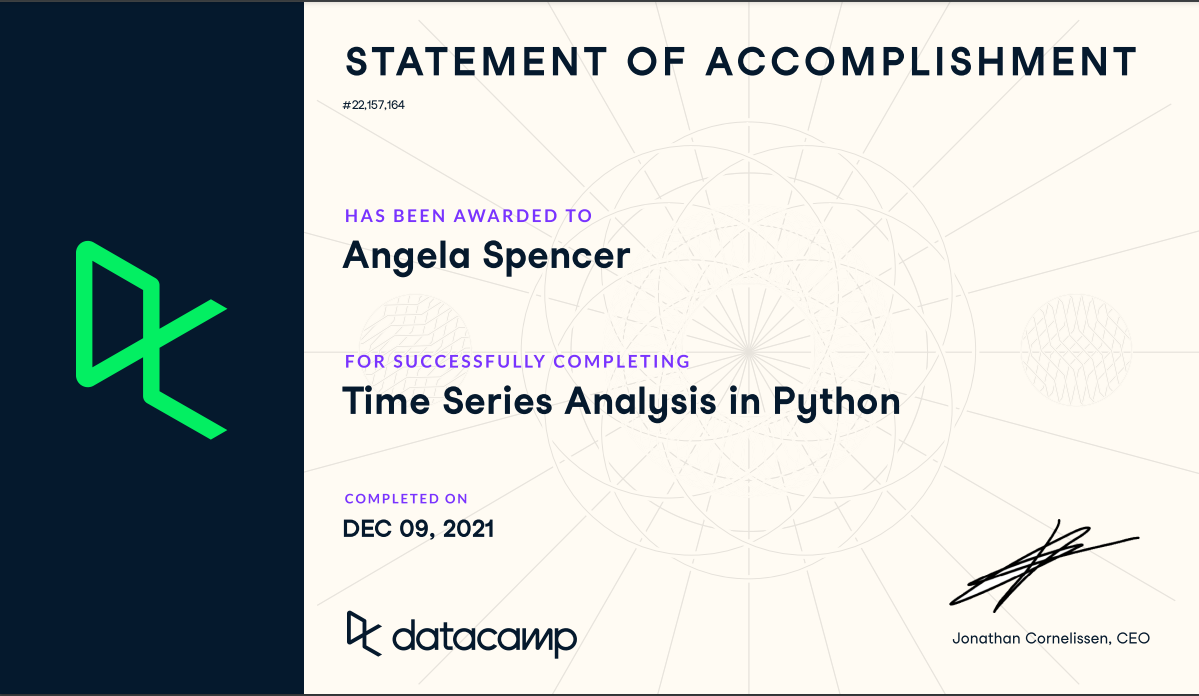

#### Bonus: What do GARCH and ARCH Stand for? Break down and explain each piece in the names. Explain the difference between the two. Create a GARCH and ARCH model on the same 5 cities from question 6. Explain and graph the results.